# Import the libraries

In [ ]:
# ============================
# 📦 Import libraries
# ============================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import itertools
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
pepsi = pd.read_csv("/content/Pepsico_Complete (3).csv").dropna()
print(pepsi.columns)


Index(['Datetime (dd/mm/yyyy)', 'Sales Volume', 'DayOfWeek', 'Hour',
       'Business_Day', 'Non_Business_Day', 'Peak_Hours', 'Non_Peak_Hours',
       'Holiday'],
      dtype='object')


In [ ]:
pepsi.head()

,Datetime (dd/mm/yyyy),Sales Volume,DayOfWeek,Hour,Business_Day,Non_Business_Day,Peak_Hours,Non_Peak_Hours,Holiday
0,2002-01-01 01:00:00,30393,1,1,True,False,False,False,False
1,2002-01-01 02:00:00,29265,1,2,True,False,False,False,False
2,2002-01-01 03:00:00,28357,1,3,True,False,False,False,False
3,2002-01-01 04:00:00,27899,1,4,True,False,False,False,False
4,2002-01-01 05:00:00,28057,1,5,True,False,False,False,False


# import Data file

In [ ]:

# ============================
# 📖 Load and preprocess data
# ============================

pepsi = pd.read_csv("/content/Pepsico_Complete (3).csv").dropna()

# Rename columns as needed for Prophet
pepsi.rename(columns={'Datetime (dd/mm/yyyy)': 'ds', 'Sales Volume': 'y'}, inplace=True)

# # Drop unused columns
# pepsi.drop(columns=['DayOfWeek', 'Hour', 'Business_Day', 'Non_Business_Day',
#                     'Peak_Hours', 'Non_Peak_Hours', 'Holiday'], inplace=True)

# Convert 'ds' column to datetime
pepsi['ds'] = pd.to_datetime(pepsi['ds'], errors='coerce')

# df = pepsi[['ds', 'y', 'Hour', 'Business_Day', 'Non_Business_Day', 'Peak_Hours', 'Non_Peak_Hours', 'Holiday']]
# df.columns = ['ds', 'y', 'Hour', 'Business_Day', 'Non_Business_Day', 'Peak_Hours', 'Non_Peak_Hours', 'Holiday']

# Train-test split
train = pepsi[pepsi['ds'] < '2018-01-01']
test  = pepsi[pepsi['ds'] >= '2018-01-01']

# Model Load

In [ ]:

# ============================
# 📊 Prophet model setup
# ============================
def add_custom_components(model):
    model.add_regressor('Business_Day')
    model.add_regressor('Peak_Hours')
    model.add_regressor('Holiday')
    model.add_regressor('Hour')

    model.add_seasonality(
        name='business_hourly',
        period=24,
        fourier_order=6,
        condition_name='is_business_day'
    )

    model.add_seasonality(
        name='non_business_hourly',
        period=24,
        fourier_order=6,
        condition_name='is_non_business_day'
    )

train['is_business_day'] = train['Business_Day']
train['is_non_business_day'] = train['Non_Business_Day']

full_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='multiplicative'
)

add_custom_components(full_model)
full_model.fit(train)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbn3rreup/qernzj_a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbn3rreup/qearpzq3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62869', 'data', 'file=/tmp/tmpbn3rreup/qernzj_a.json', 'init=/tmp/tmpbn3rreup/qearpzq3.json', 'output', 'file=/tmp/tmpbn3rreup/prophet_modelnvjmaz5w/prophet_model-20250422113513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:35:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:38:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Check if necessary columns exist
print(pepsi.columns)

# Check the length of Business_Day to ensure it's not empty
print(len(pepsi['Business_Day']))


Index(['ds', 'y', 'DayOfWeek', 'Hour', 'Business_Day', 'Non_Business_Day',
       'Peak_Hours', 'Non_Peak_Hours', 'Holiday'],
      dtype='object')
145366


In [ ]:
# Check that 'pepsi' columns are not empty
print("Length of 'Business_Day':", len(pepsi['Business_Day']))

# Ensure that 'Business_Day', 'Peak_Hours', 'Holiday', 'Hour' columns are non-empty and match the future length
assert len(pepsi['Business_Day']) > 0, "'Business_Day' column is empty"
assert len(pepsi['Peak_Hours']) > 0, "'Peak_Hours' column is empty"
assert len(pepsi['Holiday']) > 0, "'Holiday' column is empty"
assert len(pepsi['Hour']) > 0, "'Hour' column is empty"

Length of 'Business_Day': 145366


<!-- Created the Future Data Columns -->

# Create the Forecasts Values

In [ ]:
# ============================
# 📈 Generate forecasts
# ============================
# Create future dataframe - adding 7 days with hourly frequency
future = full_model.make_future_dataframe(periods=24*7, freq='H')

# Add the regressor columns to the future dataframe
# First, ensure the historical part has the correct values by merging with the original dataframe
historical_data = pepsi[['ds', 'Business_Day', 'Peak_Hours', 'Holiday', 'Hour', 'Non_Business_Day']].copy()
future = pd.merge(future, historical_data, on='ds', how='left')

# For the future dates (where we have NaN values after the merge), we need to generate reasonable values
# Let's use a simple approach: copy the pattern from the last week

# Identify where our historical data ends and future predictions begin
last_historical_date = pepsi['ds'].max()
future_dates_mask = future['ds'] > last_historical_date

# For future dates, we'll use the pattern from the same hour/day from the previous week
# First, identify which rows need filling
future_rows = future[future_dates_mask].copy()

# For each future date, find the matching hour/day from a week before
for idx, row in future_rows.iterrows():
    # Get the date from exactly one week before
    week_before = row['ds'] - pd.Timedelta(days=7)

    # Find the closest matching row in our historical data
    matching_historical = pepsi[pepsi['ds'] <= week_before].iloc[-1]

    # Copy the values
    future.loc[idx, 'Business_Day'] = matching_historical['Business_Day']
    future.loc[idx, 'Peak_Hours'] = matching_historical['Peak_Hours']
    future.loc[idx, 'Holiday'] = matching_historical['Holiday']
    future.loc[idx, 'Hour'] = matching_historical['Hour']
    future.loc[idx, 'Non_Business_Day'] = matching_historical['Non_Business_Day']

# Add conditional seasonality columns
future['is_business_day'] = future['Business_Day']
future['is_non_business_day'] = future['Non_Business_Day']

# Make predictions
forecast = full_model.predict(future)

# Show forecast results
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())


                   ds          yhat    yhat_lower    yhat_upper
0 2002-01-01 01:00:00  26511.715109  21560.655431  31614.425876
1 2002-01-01 02:00:00  25174.324438  19486.122610  30649.787768
2 2002-01-01 03:00:00  24297.838699  18805.741743  29500.170603
3 2002-01-01 04:00:00  24130.683631  18441.735662  29434.374488
4 2002-01-01 05:00:00  24819.686177  19254.468440  30074.074604


In [ ]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Business_Day,Business_Day_lower,Business_Day_upper,Holiday,...,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,yhat_std,yhat_upper_ci,yhat_lower_ci,marginal_upper,marginal_lower
0,2002-01-01 01:00:00,28355.537529,21560.655431,31614.425876,28355.537529,28355.537529,0.099697,0.099697,0.099697,0.0,...,-0.030133,0.0,0.0,0.0,26511.715109,2564.784487,30205.004770,22818.425448,32769.789257,20253.640961
1,2002-01-01 02:00:00,28355.858043,19486.122610,30649.787768,28355.858043,28355.858043,0.099697,0.099697,0.099697,0.0,...,-0.030191,0.0,0.0,0.0,25174.324438,2847.926096,29275.338016,21073.310859,32123.264113,18225.384763
2,2002-01-01 03:00:00,28356.178556,18805.741743,29500.170603,28356.178556,28356.178556,0.099697,0.099697,0.099697,0.0,...,-0.030247,0.0,0.0,0.0,24297.838699,2728.220759,28226.476592,20369.200805,30954.697352,17640.980046
3,2002-01-01 04:00:00,28356.499070,18441.735662,29434.374488,28356.499070,28356.499070,0.099697,0.099697,0.099697,0.0,...,-0.030301,0.0,0.0,0.0,24130.683631,2804.296128,28168.870056,20092.497207,30973.166184,17288.201079
4,2002-01-01 05:00:00,28356.819583,19254.468440,30074.074604,28356.819583,28356.819583,0.099697,0.099697,0.099697,0.0,...,-0.030352,0.0,0.0,0.0,24819.686177,2760.154332,28794.308415,20845.063939,31554.462747,18084.909607


# how to calculate the Confidence interval

In [ ]:

# ============================
# 🎯 Confidence intervals function
# ============================
def calculate_confidence_intervals(forecast, z_score=1.44, std_dev_multiplier=1):
    forecast['yhat_std'] = (forecast['yhat_upper'] - forecast['yhat_lower']) / (2 * stats.norm.ppf(0.975))
    ci_width = z_score * forecast['yhat_std']
    forecast['yhat_upper_ci'] = forecast['yhat'] + ci_width
    forecast['yhat_lower_ci'] = forecast['yhat'] - ci_width
    marginal_adjustment = std_dev_multiplier * forecast['yhat_std']
    forecast['marginal_upper'] = forecast['yhat_upper_ci'] + marginal_adjustment
    forecast['marginal_lower'] = forecast['yhat_lower_ci'] - marginal_adjustment
    return forecast

forecast = calculate_confidence_intervals(forecast)

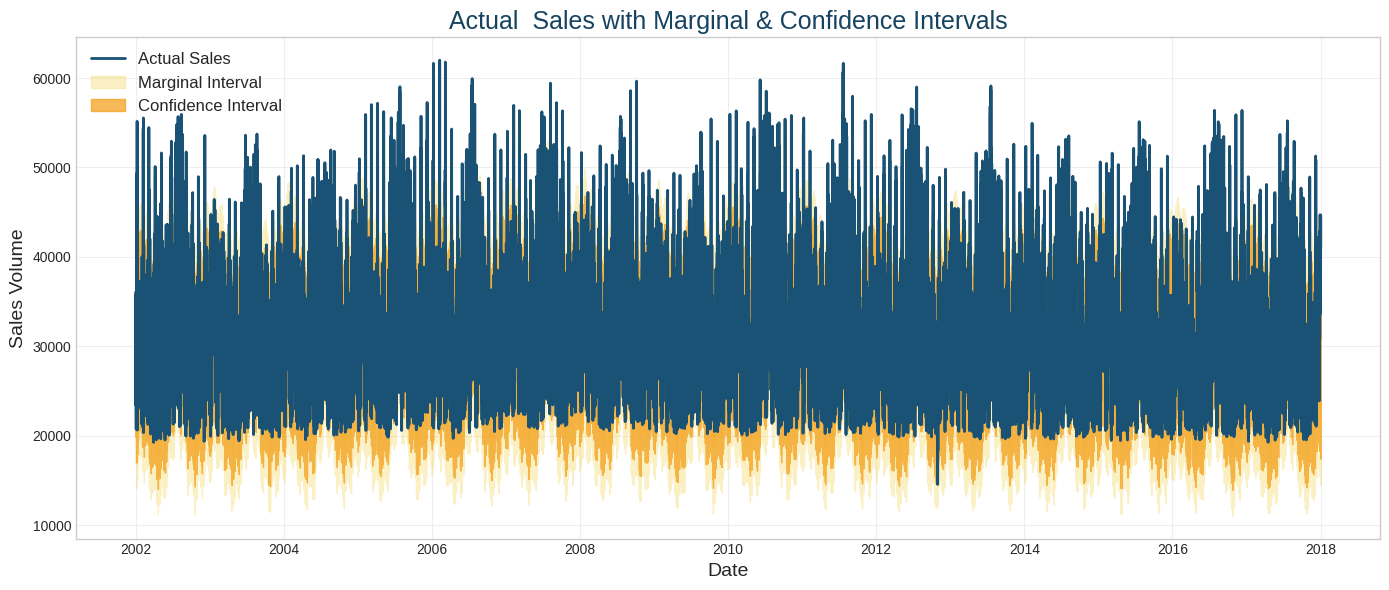

In [ ]:
# ============================
# 📊 Plot 1: Training with Intuitive, Vibrant Colors
# ============================
train_forecast = forecast[forecast['ds'] < '2018-01-01']
plt.figure(figsize=(14, 6))

# Plot actual sales values
plt.plot(train['ds'], train['y'], label='Actual Sales', color='#1A5276', linewidth=2)

# Plot Marginal Interval (wider band — background)
plt.fill_between(train_forecast['ds'],
                 train_forecast['marginal_lower'],
                 train_forecast['marginal_upper'],
                 color='#F4D03F',  # Light yellow
                 alpha=0.3,
                 label='Marginal Interval')

# Plot Confidence Interval (narrower band — foreground)
plt.fill_between(train_forecast['ds'],
                 train_forecast['yhat_lower_ci'],
                 train_forecast['yhat_upper_ci'],
                 color='#F39C12',  # Vibrant orange
                 alpha=0.7,
                 label='Confidence Interval')

# Titles, labels, grid, legend
plt.title('Actual  Sales with Marginal & Confidence Intervals', fontsize=18, color='#154360')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales Volume', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




In [ ]:
train_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Business_Day,Business_Day_lower,Business_Day_upper,Holiday,...,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,yhat_std,yhat_upper_ci,yhat_lower_ci,marginal_upper,marginal_lower
0,2002-01-01 01:00:00,28355.537529,21560.655431,31614.425876,28355.537529,28355.537529,0.099697,0.099697,0.099697,0.0,...,-0.030133,0.0,0.0,0.0,26511.715109,2564.784487,30205.004770,22818.425448,32769.789257,20253.640961
1,2002-01-01 02:00:00,28355.858043,19486.122610,30649.787768,28355.858043,28355.858043,0.099697,0.099697,0.099697,0.0,...,-0.030191,0.0,0.0,0.0,25174.324438,2847.926096,29275.338016,21073.310859,32123.264113,18225.384763
2,2002-01-01 03:00:00,28356.178556,18805.741743,29500.170603,28356.178556,28356.178556,0.099697,0.099697,0.099697,0.0,...,-0.030247,0.0,0.0,0.0,24297.838699,2728.220759,28226.476592,20369.200805,30954.697352,17640.980046
3,2002-01-01 04:00:00,28356.499070,18441.735662,29434.374488,28356.499070,28356.499070,0.099697,0.099697,0.099697,0.0,...,-0.030301,0.0,0.0,0.0,24130.683631,2804.296128,28168.870056,20092.497207,30973.166184,17288.201079
4,2002-01-01 05:00:00,28356.819583,19254.468440,30074.074604,28356.819583,28356.819583,0.099697,0.099697,0.099697,0.0,...,-0.030352,0.0,0.0,0.0,24819.686177,2760.154332,28794.308415,20845.063939,31554.462747,18084.909607


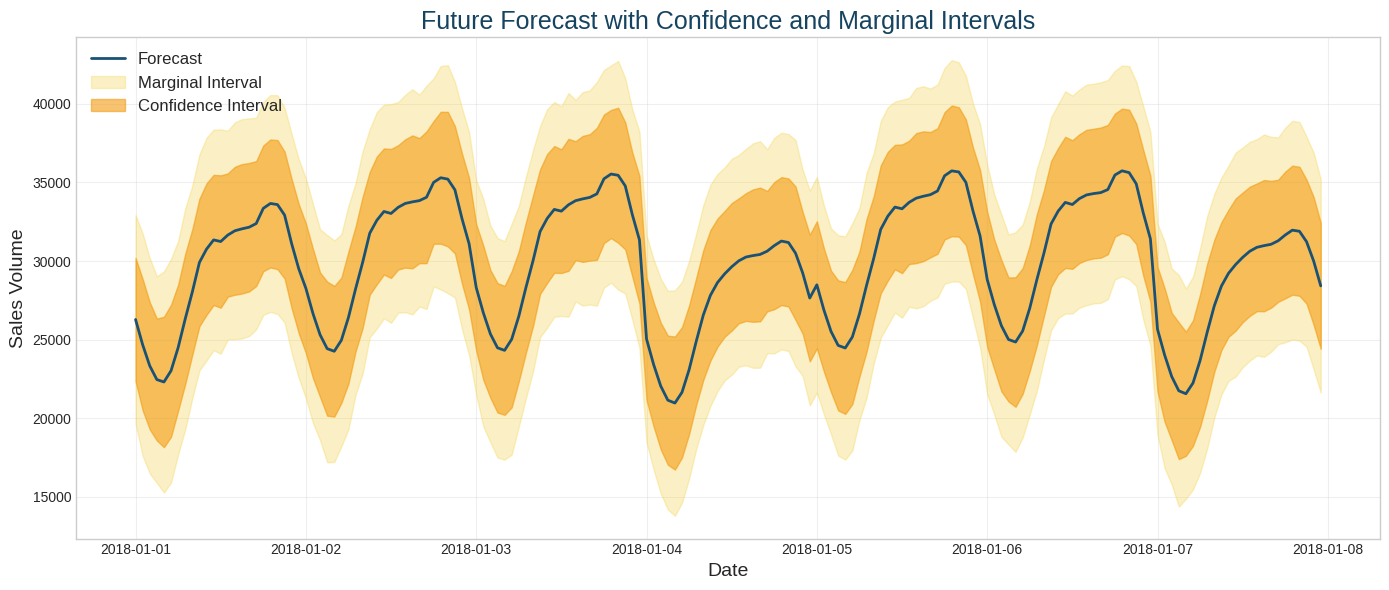

In [ ]:
# 📊 Plot 2: Forecast future + confidence and marginal interval
future_forecast = forecast[forecast['ds'] >= '2018-01-01']

plt.figure(figsize=(14, 6))

# Forecasted sales line
plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Forecast', color='#1A5276', linewidth=2)

# Marginal interval (wider band — background)
plt.fill_between(future_forecast['ds'],
                 future_forecast['marginal_lower'],
                 future_forecast['marginal_upper'],
                 color='#F4D03F',  # Light Yellow
                 alpha=0.3,
                 label='Marginal Interval')

# Confidence interval (narrower band — foreground)
plt.fill_between(future_forecast['ds'],
                 future_forecast['yhat_lower_ci'],
                 future_forecast['yhat_upper_ci'],
                 color='#F39C12',  # Vibrant Orange
                 alpha=0.6,
                 label='Confidence Interval')

# Titles, labels, legend, grid
plt.title('Future Forecast with Confidence and Marginal Intervals', fontsize=18, color='#154360')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales Volume', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

